In [4]:
import nibabel as nb 
import numpy as np
import pandas 
import seaborn as sns
import matplotlib.pyplot as plt
from Functional_Fusion.dataset import decompose_pattern_into_group_indiv_noise
from scripts import decomposing_variances
from scripts import make_atlas
#from scripts import bold_normalization 
import Functional_Fusion.dataset as ds
import Functional_Fusion.atlas_map as am

In [15]:
#dentate data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='dentate', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_dent = np.mean(run_avg, axis=1)

print(cond_avg_dent)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])




[ 0.00224486  0.00245442  0.01333977 -0.00118769  0.00347054 -0.00300671
 -0.01035416  0.00958945 -0.00761015 -0.00894033]


In [16]:
#redn data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='rednucleus', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_redn = np.mean(run_avg, axis=1)

print(cond_avg_redn)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])




vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
/Users/incehusain/Documents/GitHub/Pontine7T/env/lib/python3.9/site-packages/nibabel/nifti1.py:617: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value


vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compa

[ 0.00350441  0.0049634   0.00947999  0.00075478 -0.00232617 -0.0014441
 -0.00429931  0.00566744 -0.0092844  -0.00701604]


In [17]:
#olive data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='olive', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_olive = np.mean(run_avg, axis=1)

print(cond_avg_olive)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
/Users/incehusain/Documents/GitHub/Pontine7T/env/lib/python3.9/site-packages/nibabel/nifti1.py:617: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
v

[ 0.00643612  0.00298557  0.00521756  0.00505443  0.00132745 -0.00461602
 -0.00962462  0.00994499 -0.00793588 -0.00878961]


In [23]:
#pons data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='pontine', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_pons = np.mean(run_avg, axis=1)

print(cond_avg_pons)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
/Users/incehusain/Documents/GitHub/Pontine7T/env/lib/python3.9/site-packages/nibabel/nifti1.py:617: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at curren

[ 0.00312729 -0.00451581  0.00193929  0.00092854 -0.00226789 -0.00392753
 -0.00101905  0.00690104 -0.00042661 -0.00073925]


In [25]:
#thalamus data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='thalamus', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_thalamus = np.mean(run_avg, axis=1)

print(cond_avg_thalamus)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



[ 2.75664719e-03  8.54102964e-04  3.98791960e-03  4.66870032e-05
  2.44709811e-05 -2.08492712e-03 -1.27704808e-03  7.14029172e-04
 -3.84814221e-03 -1.17373950e-03]


In [27]:
#cereb gray data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='cereb_gray', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_cereb_gray = np.mean(run_avg, axis=1)

print(cond_avg_cereb_gray)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



[ 0.00577893  0.00025809  0.02435791  0.00173379  0.00254675 -0.00528998
 -0.00601337  0.00736007 -0.01711001 -0.01362216]


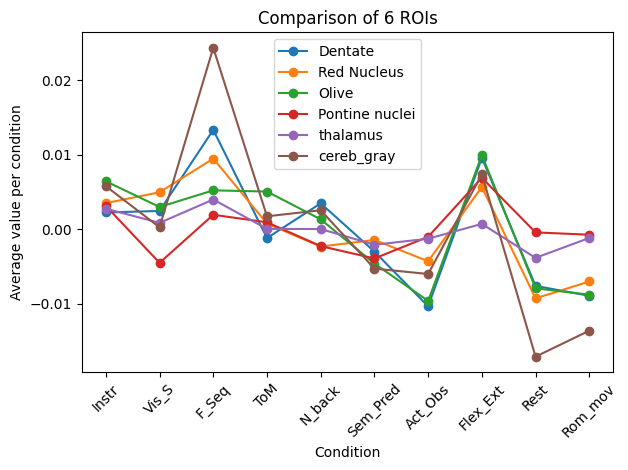

In [44]:
# Create x-axis labels (1 to 10 for the 10 conditions)
condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"])

# Plot both lines
plt.plot(condition_labels, cond_avg_dent, marker='o', label='Dentate', linestyle='-')
plt.plot(condition_labels, cond_avg_redn, marker='o', label='Red Nucleus', linestyle='-')
plt.plot(condition_labels, cond_avg_olive, marker='o', label='Olive', linestyle='-')
plt.plot(condition_labels, cond_avg_pons, marker='o', label='Pontine nuclei', linestyle='-')
plt.plot(condition_labels, cond_avg_thalamus, marker='o', label='thalamus', linestyle='-')
plt.plot(condition_labels, cond_avg_cereb_gray, marker='o', label='cereb_gray', linestyle='-')



# Labels and title
plt.xlabel("Condition")
plt.ylabel("Average value per condition")
plt.title("Comparison of 6 ROIs")

plt.xticks(rotation=45, fontsize=10)

plt.legend()
plt.tight_layout()

# Show plot
plt.show()

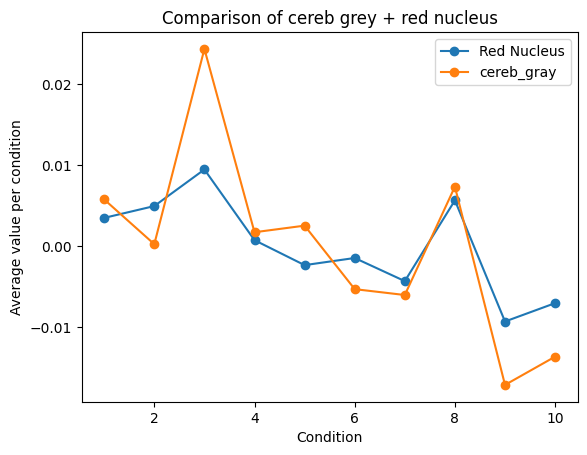

In [40]:
# Create x-axis labels (1 to 10 for the 10 conditions)
conditions = np.arange(1, 11)

# Plot both lines
#plt.plot(conditions, cond_avg_dent, marker='o', label='Dentate', linestyle='-')
plt.plot(conditions, cond_avg_redn, marker='o', label='Red Nucleus', linestyle='-')
#plt.plot(conditions, cond_avg_olive, marker='o', label='Olive', linestyle='-')
#plt.plot(conditions, cond_avg_pons, marker='o', label='Pontine nuclei', linestyle='-')
#plt.plot(conditions, cond_avg_thalamus, marker='o', label='thalamus', linestyle='-')
plt.plot(conditions, cond_avg_cereb_gray, marker='o', label='cereb_gray', linestyle='-')



# Labels and title
plt.xlabel("Condition")
plt.ylabel("Average value per condition")
plt.title("Comparison of cereb grey + red nucleus")
plt.legend()

# Show plot
plt.show()